# Topic Map

In [193]:
import os
import pandas as pd
import re
import nltk
import openai
import matplotlib
import matplotlib.pyplot as plt
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from bertopic import BERTopic
from nltk import sent_tokenize, word_tokenize
# nltk.download('punkt') < uncomment when you run it first time

pd.set_option('display.max_colwidth', None)
data_dir = '../data/'
processed_dir = data_dir + 'processed/'
os.makedirs(processed_dir + 'html', exist_ok = True)
os.makedirs(processed_dir + 'topic-map', exist_ok = True)
transcription_dir_location_en = processed_dir + 'transcription/en/'

## Parse Audio Transcriptions

To be able to topic model a text corpus some pre-processing is required. As the audio is spoken word some filler words need removed, inconsistent phrases like `Fratelli d'Italia` was converted to `Brothers of Italy` and Law `one hundred and ninety-four` to `194`. Posts with less than 27 words were ignored.

The topic model works best with individual sentences which were also keyed by the post date so that topics could be visualised over time. The complete parsed sentences were saved in a file to help with manual analysis.   

In [201]:
docs = []
filenames = []
timestamps = []
docs_word_count = []
# TODO sort by date

# the text contains spoken filler words that need removed 
stopwords = ['um', 'um,', 'mm,', 'eh', 'eh,', 'eh?', 'ah', 'ah,', 'mhm', 'mhm.', 'oh', 'oh,', 'oh.', 'huh?', 'hi']     
# RegExs for significant phrases 
FDI = re.compile(re.escape("fratelli d'italia"), re.IGNORECASE)
ninety_four = re.compile(re.escape("ninety four"), re.IGNORECASE)
one_hundred_and_ninety_four = re.compile(re.escape("one hundred and ninety-four"), re.IGNORECASE)

from datetime import datetime
 
DATE_TIME_FORMAT = '%Y-%m-%d %H:%M:%S'

def sort_dates(dates):
    # Define a key function that converts a date string to a datetime object
    def date_key(date_string):
        return datetime.strptime(date_string, DATE_TIME_FORMAT) # 2023-01-17 19:44:01 '%m/%d/%Y %I:%M %p'
     
    return sorted(dates, key=lambda x: date_key(x[0]))

def remove_stop_words(sentence):
    text_tokens = sentence.split(" ")
    tokens_filtered = [word for word in text_tokens if not word.lower() in stopwords]
    return (" ").join(tokens_filtered)

def parse_text(file_location): 
    transcriptions_df = pd.read_json(file_location, convert_dates=['createTime'])
    transcription_text = transcriptions_df['transcript'][0]
    transcription_create_time = transcriptions_df['createTime'][0].strftime(DATE_TIME_FORMAT)
    word_count = len(transcription_text.split()) 
    # only analyse files with sentences with more then 27 words
    if word_count < 27:
        print(f'Small number of words: {file_location} {transcription_text}')
        return
    docs_word_count.append(word_count)

    for sentence in sent_tokenize(transcription_text):
        timestamps.append(transcription_create_time)
        sentence = FDI.sub('Brothers of Italy', sentence)
        sentence = ninety_four.sub('ninety-four', sentence)
        sentence = one_hundred_and_ninety_four.sub('194', sentence)
        sentence = remove_stop_words(sentence)   
        filenames.append(file_location.removeprefix('../data/processed/transcription/en/TranscribeTikTokAudio').removesuffix('.json'))              
        docs.append(sentence)
    
for file_name in os.listdir(transcription_dir_location_en):
    parse_text(transcription_dir_location_en + file_name)

print(len(timestamps))
print(len(docs))
print(len(filenames))

docs_dict = zip(timestamps, filenames, docs)
  
sorted_dates = sort_dates(list(docs_dict))

with open(processed_dir + '/topic-map/all-docs-text.txt', 'w') as file: 
 	file.writelines('{0} \n'.format(value) for value in sorted_dates) 

word_count_df = pd.DataFrame(zip(timestamps, docs_word_count), columns=['timestamp','word_count'])  
word_count_df.to_json(processed_dir + '/wordcount.json')

start_date = '2022-07-21'
end_date = '2022-09-26'

docs_df = pd.DataFrame(zip(timestamps, docs), columns=['timestamp','docs'])  

mask = (docs_df['timestamp'] > start_date) & (docs_df['timestamp'] <= end_date)
election_dates_df = docs_df.loc[mask]


Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7147206448232074502.json gentlemen, It was the day of defeat. But this is not the day to get things done. Well, that wasn't really the case. That's fine. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7147263913200045317.json September twenty-fifth I've said it all. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7135145359629634822.json 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7144425341279341830.json I am
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7070073900100521222.json who goes M design, yo. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7144420910336953606.json 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7143163842665663749.json 
Small number of words: ../data/processed/transcription/en/Transcribe

## Topic Model

The steps that follow configure BERTopic so that is can run and create a topic model. For more information see the BERTopic documentation and the best practices.

### Pre-calculate Embeddings

In [202]:
from bertopic.backend import OpenAIBackend

# all-mpnet-base-v2 - is the best embedding model but slow
embedding_model = SentenceTransformer('all-mpnet-base-v2')
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/74 [00:00<?, ?it/s]

### Stochastic Behaviour

In [203]:
from bertopic import BERTopic
from sklearn.decomposition import PCA

# umap_model = PCA()
umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=42)

### Cluster - Limit Number of Topics

In [359]:
import numpy as np  
hdbscan_model = HDBSCAN(
    min_cluster_size=10, 
    metric='euclidean', 
    cluster_selection_method='eom', 
    min_samples=8, # added to reduce outliers
    prediction_data=True)

### Improving Default Representation

This isn't used as it seemed to remove words that were important.  

In [205]:
vectorizer_model = CountVectorizer(stop_words="english")

### Representation Models

In [275]:
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# Chat-GPT-3.5
openai.api_key=os.environ['openai_api_key'] 
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
openai_model = OpenAI(model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)

from bertopic.representation import ZeroShotClassification

candidate_topics = [
    'migrants', 
    'abortion', 
    'fake news', 
    'Brothers of Italy', 
    'we are ready',
    'rape',
    'Nazis',
    'minimum wage',
    'ecological',
    'green pass',
    'russia'
    'crime', # this is used to separate out crime from migration
    'authoritarian',
    'women',
    'inflation', 
    'citizenship', 
    'freedom',
    'prices',
    'pensions',
    'tax',
    'family',
    ]

zero_shot_model = ZeroShotClassification(candidate_topics, model="facebook/bart-large-mnli")
representation_model = zero_shot_model
# representation_model = {
#     "Main": zero_shot_model,
#     # 'OpenAI': openai_model,  # Uncomment if you will use OpenAI
#     # 'MMR': mmr_model,
#     # 'KeyBERT': keybert_model,
#     # 'POS': pos_model,
# }

### Seed Topics

These are used to encourage the topic model to map domain relevant topics.

In [250]:
seed_topic_list = [  
    ['Brothers of Italy', 'brothers of italy', 'Italy', 'Italian'],
    ['we are ready'], # The FDI's Campaign slogan     
    ['immigration', 'migration', 'migrants', 'refugee', 'traffickers'],
    ['abortion', 'abort', '194', 'law 194'],
    ['election', 'government', 'vote'],
    ['inflation', 'bills'],
    ['freedom'],
    ['rape', 'raped'],
    ['women'],
    ['climate' , 'environmental', 'ecological',  'sustainability'],
    ['fake', 'fake news', 'lies', 'journalism'],
    ['tax', 'income'],
    ['crime'],
    ['minimum wage'],
    ['Nazis', 'nazis'],
    ['pensions'],
    ['family', 'families'],
    ['pets', 'animals'], # added as pets get merge into the migrants topic    
    ['russia']       
    ]

Run the Topic Model

Now that BERTopic is configured it can be run. The output is a list of topics and associated topic counts. The first row is a group of outliers that are not used in the topic model. 

In [332]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True, bm25_weighting=True)

topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  # vectorizer_model=                       # Step 4 - Tokenize topics. Don't do this! It removed the entire abortion topic.
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  seed_topic_list=seed_topic_list,
  min_topic_size=10, # 10 is the default
  nr_topics=29, # 32
  verbose=True,
  n_gram_range=(1,3), # allows Brothers of Italy
  calculate_probabilities=True,
)

topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

Batches:   0%|          | 0/74 [00:00<?, ?it/s]

2023-11-23 11:36:19,696 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-23 11:36:27,709 - BERTopic - Reduced dimensionality
2023-11-23 11:36:28,054 - BERTopic - Clustered reduced embeddings
2023-11-23 11:42:33,975 - BERTopic - Reduced number of topics from 55 to 29


,Topic,Count,Name,Representation,Representative_Docs
0,-1,597,-1_have_this_be_we,"[have, this, be, we, are, government, on, in, we have, because]","[For this reason, the objective of our work must also be to find the resources necessary to carry out these development initiatives, involving not only states and international organizations, but also enhancing private and entrepreneurial initiatives.. And I am sure that the discussion that we are about to start in this session, in the following one, which also involves international financial organizations and institutions, will direct us towards ambitious and shared goals., If it is true that the homeland is a mother, that mother is there in a moment like this and therefore I wanted to express the thanks of the nation that you and I represent for the work you do, for the sacrifices you make, for how you manage , with your work, your dedication and the difficulties that this entails, because they are personal sacrifices and sacrifices of which we are and are perfectly aware, which however give the nation extraordinary luster, great opportunities., First of all because many probably expected a little Italy, spaghetti and mandolin which, when faced with difficulties, always turns the other way in the end and instead we have been something else, we are something else and look at this, it's not just a fact of pride is a matter of defense of the national interest, because when you are authoritative, when you are credible your voice is also listened to and when your voice is listened to then yes you can obtain results for your national interest.]"
1,0,359,0_italy_brothers of italy_of italy_brothers,"[italy, brothers of italy, of italy, brothers, italian, brothers of, in italy, government, italians, meloni]","[The point is that I have to understand how the management of public order works, because if public order allows these people to start insulting Brothers of Italy and Giorgia Meloni among the supporters of Brothers of Italy and Giorgia Meloni, the risk that someone could get nervous at a certain point and that this could lead to accidents doesn't occur to anyone that it could then happen the first time and okay the second time and okay the third time and you already have the problem the fourth time the fifth This morning I called Minister Lamorgese and said sorry Minister, but do you realize that having protesters arrive who insult you?, This instability has produced our economic weakness, it has produced the credibility problems that we may have also had at an international level, when our interlocutors often remain the same interlocutor for at least a few years and every time they sit with an Italian exponent they ask themselves the next once again, who knows if this person will be my interlocutor again on the part of Italy and they have produced the disaffection on the part of the citizens that we see and to deliver to Italy a reform which, let's be clear, we are doing for ourselves, because it is a reform which we hand over to the next government and therefore we hand over to all the political forces., The theme here is if you want to do something, whatever you want to do, you do it respecting the rules and laws of the Italian state because there isn't some idiot who respects them and someone else who doesn't have to respect them, this Italy here, as I see it, it's over, that is, someone who knows how to do it better make their proposals but don't use hypotheses that have nothing to do with the rationale of the law and with our intention to prevent this State from saying that we are no longer the banana republic, because I don't follow them on this, I move forward and I believe that this is what Italians expect from me and from the government currently in office]"
2,1,235,1_european_the european_government_this,"[european, the european, government, this, it, we, from, migration, council, the european council]","[In short, having been in parliament for a few years, I also know th

Rename Topics

In [366]:
def formatted_label(topic_model, index, labels):
    names = [item.replace(',', '').strip().title() for item in labels if item.strip()]
    
    top_three = ', '.join(names[:3]) \
        .replace('Green Pass', 'COVID Mandates') \
        .replace('Abortion, 194, The 194', 'Abortion') \
        .replace('Italy, Brothers Of Italy, Of Italy', 'Brothers Of Italy') \
        .replace('Family, Christmas, Nativity', 'Family') \
        .replace('Thank You, Thank, We Are Ready', 'We Are Ready!') \
        .replace('Rape, Enough, Of Rape', 'Rape') \
        
    
    offset = index - 1 # this hack is for the index by topic id to include the outliers at -1
    label = {offset : top_three}
    # print(label)
    topic_model.set_topic_labels(label)

# name_column = topic_model.get_topic_info()['ZeroShot']
print(topic_model.get_topic_info().columns)
print(topic_model.get_topic_info().shape[0])
name_column = topic_model.get_topic_info()['Representation']    
for label, index in enumerate(name_column):
    formatted_label(topic_model, label, index) 

topic_model.get_topic_info().head(50)

Index(['Topic', 'Count', 'Name', 'CustomName', 'Representation',
       'Representative_Docs'],
      dtype='object')
29


,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,-1,597,-1_have_this_be_we,"Have, This, Be","[have, this, be, we, are, government, on, in, we have, because]","[For this reason, the objective of our work must also be to find the resources necessary to carry out these development initiatives, involving not only states and international organizations, but also enhancing private and entrepreneurial initiatives.. And I am sure that the discussion that we are about to start in this session, in the following one, which also involves international financial organizations and institutions, will direct us towards ambitious and shared goals., If it is true that the homeland is a mother, that mother is there in a moment like this and therefore I wanted to express the thanks of the nation that you and I represent for the work you do, for the sacrifices you make, for how you manage , with your work, your dedication and the difficulties that this entails, because they are personal sacrifices and sacrifices of which we are and are perfectly aware, which however give the nation extraordinary luster, great opportunities., First of all because many probably expected a little Italy, spaghetti and mandolin which, when faced with difficulties, always turns the other way in the end and instead we have been something else, we are something else and look at this, it's not just a fact of pride is a matter of defense of the national interest, because when you are authoritative, when you are credible your voice is also listened to and when your voice is listened to then yes you can obtain results for your national interest.]"
1,0,359,0_italy_brothers of italy_of italy_brothers,Brothers Of Italy,"[italy, brothers of italy, of italy, brothers, italian, brothers of, in italy, government, italians, meloni]","[The point is that I have to understand how the management of public order works, because if public order allows these people to start insulting Brothers of Italy and Giorgia Meloni among the supporters of Brothers of Italy and Giorgia Meloni, the risk that someone could get nervous at a certain point and that this could lead to accidents doesn't occur to anyone that it could then happen the first time and okay the second time and okay the third time and you already have the problem the fourth time the fifth This morning I called Minister Lamorgese and said sorry Minister, but do you realize that having protesters arrive who insult you?, This instability has produced our economic weakness, it has produced the credibility problems that we may have also had at an international level, when our interlocutors often remain the same interlocutor for at least a few years and every time they sit with an Italian exponent they ask themselves the next once again, who knows if this person will be my interlocutor again on the part of Italy and they have produced the disaffection on the part of the citizens that we see and to deliver to Italy a reform which, let's be clear, we are doing for ourselves, because it is a reform which we hand over to the next government and therefore we hand over to all the political forces., The theme here is if you want to do something, whatever you want to do, you do it respecting the rules and laws of the Italian state because there isn't some idiot who respects them and someone else who doesn't have to respect them, this Italy here, as I see it, it's over, that is, someone who knows how to do it better make their proposals but don't use hypotheses that have nothing to do with the rationale of the law and with our intention to prevent this State from saying that we are no longer the banana republic, because I don't follow them on this, I move forward and I believe that this is what Italians expect from me and from the government currently in office]"
2,1,235,1_european_the european_government_this,"European, The European, Government","[european, the european, government, this, it, we, from, migration, council, the europ

In [363]:
heatmap_fig = topic_model.visualize_heatmap(custom_labels=True) # n_clusters=20, topics=[4, 18, 26, 21,44]
heatmap_fig.write_html(processed_dir + 'html/similarity-matrix.html')
heatmap_fig

### Visualise Topic Frequency Count 

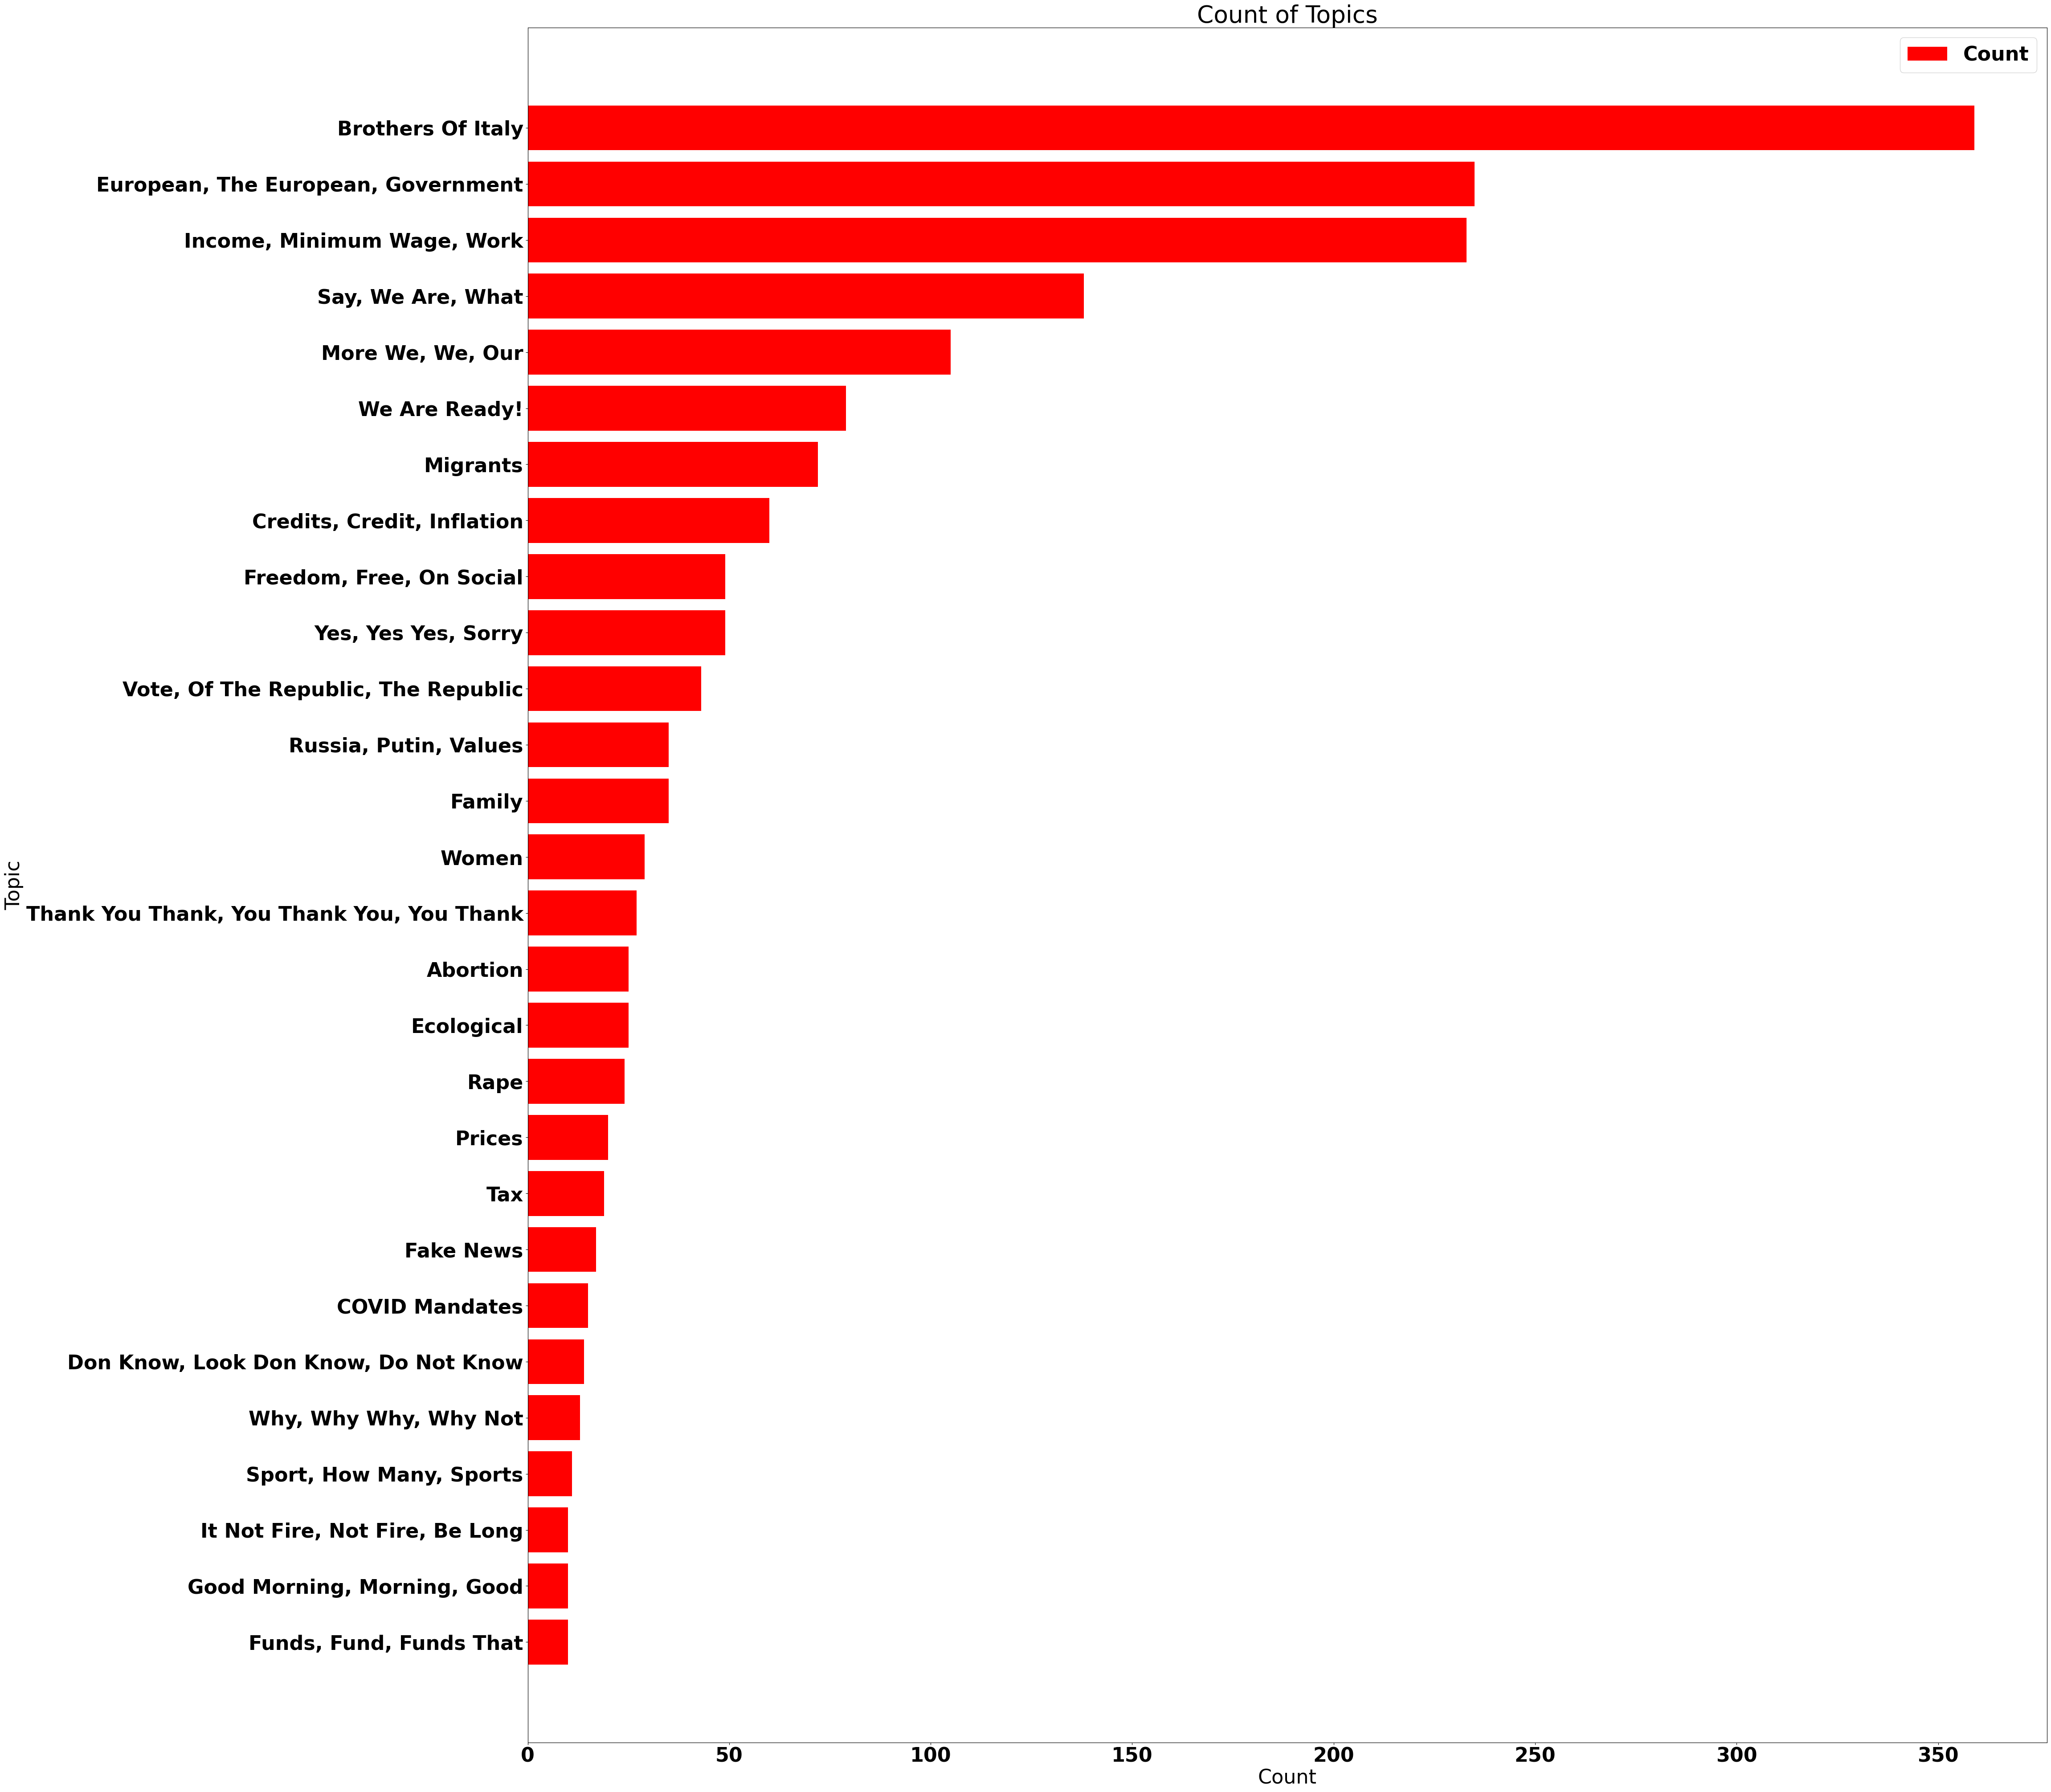

In [367]:
plt_df = topic_model.get_topic_info()
# drop the outliers
plt_df = plt_df.drop([0])
plt_df = plt_df.sort_values(by='Count', ascending=True)

f = plt.figure()
f.set_figwidth(44)
f.set_figheight(50)
plt.barh(plt_df['CustomName'], plt_df['Count'], label = "Count", color='red')
font = {'weight' : 'bold',
        'size'   : 32}
plt.rc('font', **font)

plt.title('Count of Topics')
plt.xlabel('Count')
plt.ylabel('Topic')

plt.legend()
plt.savefig(processed_dir + 'images/topic-document-counts.png')
plt.show()

Show the documents in a particular topic

In [373]:
fig = topic_model.visualize_barchart(width=280, height=330, top_n_topics=60, n_words=13, custom_labels=True)
fig.write_html(processed_dir + 'html/topic-word-scores.html')
fig

## Documents in Specific Topic

In [374]:
representative_docs = topic_model.get_representative_docs(3)
representative_docs

freedom = 10
fake_news = 20

df = pd.DataFrame({'Topic': topics, 'document': docs})
df[df['Topic'] == freedom].head(50)
df[df['Topic'] == fake_news].head(50)

,Topic,document
643,20,This is also a hoax.
683,20,"Easy it doesn't take much you have to study, know how to read and then but why?"
763,20,But if she is not convinced to make that choice she has another one without all the rest of the institutions being on the other side.
769,20,"If I've always said the same thing, there's probably no reason to keep making up fake news."
770,20,"I don't need to invent fake news about my opponents, I just need to say who I really am because they need to invent fake news about me."
1015,20,"don't be scared, don't be scared, it's not true."
1016,20,"Everything they told you about the elections, that they are scary, that they are a problem that stops everything, nothing stops,"
1100,20,The din of war has collapsed the progressive narrative.
1143,20,I usually tell the truth.
1297,20,"For days I have been hearing total lies, fake candidates that are sent by Italian brothers around the internet, fake parts of the program, proposals that have never existed, that when there is a need to invent lies about someone it means that that person someone is right because otherwise you don't need to lie."


## Topic Frequency

In [375]:
df_topic_freq = topic_model.get_topic_freq()
topics_count = len(df_topic_freq) - 1
df_topic_freq

,Topic,Count
1,-1,597
4,0,359
0,1,235
10,2,233
12,3,138
7,4,105
5,5,79
9,6,72
2,7,60
21,8,49


## Visualise Topics

In [376]:
fig = topic_model.visualize_topics(custom_labels=True)
fig.write_html(processed_dir + 'html/inter-topic-distance-map.html')
fig

## Topics over time 

Make sure to use a limited number of unique timestamps (<100) as the c-TF-IDF representation will be calculated at each single unique timestamp. Having a large number of unique timestamps can take some time to be calculated. Moreover, there aren't many use-cased where you would like to see the difference in topic representations over more than 100 different timestamps.

In [372]:
topics_over_time = topic_model.topics_over_time(docs, timestamps)
intertopic_fig = topic_model.visualize_topics_over_time(topics_over_time=topics_over_time, custom_labels=True)
intertopic_fig.write_html(processed_dir + 'html/topics-over-time.html')
intertopic_fig

0it [00:00, ?it/s]

168it [1:03:00, 22.50s/it]


In [377]:
documents_and_topics_fig = topic_model.visualize_documents(docs, topics=topics, custom_labels=True)
documents_and_topics_fig.write_html(processed_dir + 'html/documents-and-topics.html')
documents_and_topics_fig

In [378]:
doc_id = 123
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)
topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id])

100%|██████████| 3/3 [00:00<00:00,  4.14it/s]


,whatever,have,done,in,my,life,most,have,bet,on,my,failure,it,has,something,to,do,with,the,fact,that,was,woman,probably,yes,and,it,is,something,that,realized,very,late,in,my,existence
13_women___,0.000,0.000,0.000,0.000,0.000,0.103,0.205,0.308,0.416,0.415,0.314,0.210,0.102,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.104,0.207,0.207,0.207,0.103,0.000,0.000,0.000,0.104,0.208,0.309,0.415,0.311,0.207,0.106
